## Parameter estimation
### Parameter estimation via MCMC will be considered on the back-transformed output of the proposed model, to test the performance of the imputation.

## Setting up

In [3]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('../models'))

In [12]:
###loading
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from LISA_utils import FFT, freq_PSD, inner_prod

import torch
import torch.nn as nn

In [6]:
#########################
#data from DCAE
##########################
from DCAE import Autoencoder

# Create an instance of the autoencoder
autoencoder = torch.load('../models/models_dcae.pth')

### Setting the time range
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

######################
#BI_GRU import
######################
from bi_GRU import BidirectionalGRUModel

model = torch.load('../models/models_ae_gru.pth')

######################
# time setting up
######################

tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

#### Since the exact waveform is known, the window function is applied in the Bayesian inference process for the signal with gaps, called ``corrupted" signals.

In [21]:
######################################
### gap with window function
######################################
def gap_function(t,start_window,end_window,lobe_length, gap_flag = True):
    if gap_flag == True:
        one_hour = 60*60
        start_window *= one_hour          # Define start of gap
        end_window *= one_hour          # Define end of gap
        lobe_length *= one_hour          # Define length of cosine lobes

        delta_t = t[1] - t[0]
        window_length = int(np.ceil(((end_window+lobe_length) - 
                                    (start_window - lobe_length))/delta_t))  # Construct of length of window 
                                                                            # throughout the gap
        alpha_gaps = 2*lobe_length/(delta_t*window_length)      # Construct alpha (windowing parameter)
                                                        # so that we window BEFORE the gap takes place.
            
        window = tukey(window_length,alpha_gaps)   # Construct window

        gap = []  # Initialise with empty vector
        j=0  
        for i in range(0,len(t)):   # loop index i through length of t
            if t[i] > (start_window - lobe_length) and (t[i] < end_window + lobe_length):  # if t within gap segment
                gap.append(1 - window[j])  # add windowing function to vector of ones.
                j+=1  # incremement 
            else:                   # if t not within the gap segment
                gap.append(1)  # Just add a onne.
                j=0
                

        alpha_full = 0
        total_window = tukey(len(gap), alpha = alpha_full)

        gap *= total_window
    else:
        gap = np.ones(len(t))
    return gap

lambda_value = 0.75

def ge_unsche(t):
    w = np.ones(int(np.random.exponential(scale=1/lambda_value))*24*60*12)
    while len(w) <= len(t):
        durations = int(np.random.uniform(8,12))*60*60
        tt = np.arange(0,durations,delta_t) 
        gap_window_tt = gap_function(tt, start_window =2 , end_window = durations/60/60-2, lobe_length = 2, gap_flag = True) # defined in hours! 
        w = np.append(w, gap_window_tt)
        w = np.append(w, np.ones(int(np.random.exponential(scale=1/lambda_value))*24*60*12))
    return w[:len(t)]


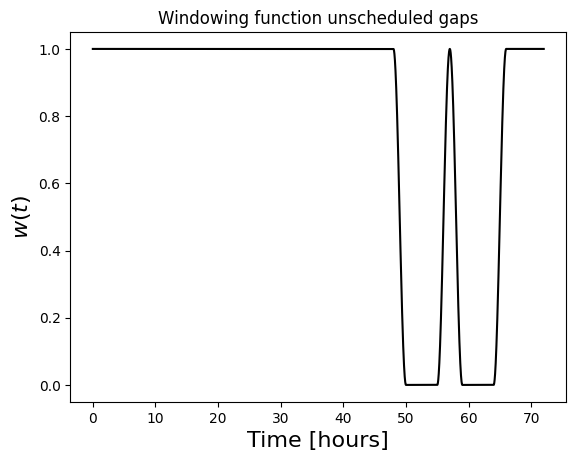

In [22]:
# Plot the signal

plt.plot(t/60/60,unscheduled_gap, label = "window function unschedule", c = 'black')
plt.xlabel(r'Time [hours]', fontsize = 16)
plt.ylabel(r'$w(t)$', fontsize = 16)
plt.title(r'Windowing function unscheduled gaps')
plt.show()

In [23]:
##############
# the signal
##############
a_true = 5e-21
f_true = 1e-3
fdot_true = 1e-8
signal=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))

(51840,)

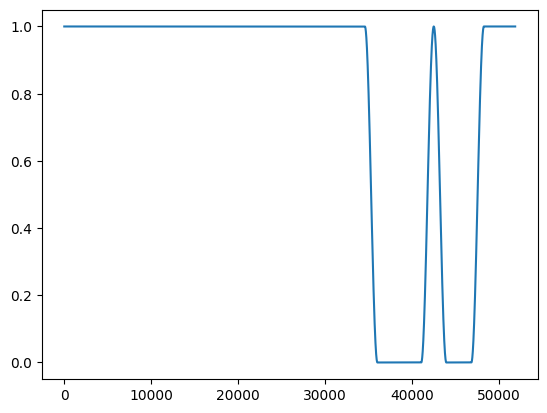

In [31]:
#####################
## signal corruption
#####################
cortestmask=ge_unsche(t)
plt.plot(cortestmask)
maskinautoencoder=cortestmask != 0
maskinautoencoder = maskinautoencoder.astype(int)

cortestsig=signal*maskinautoencoder
cortestsig.shape


In [36]:
#####################
# DCAE
#####################
testsig=signal
testinput=torch.tensor(testsig.reshape((1,1,-1)))
snodata,normaldata,mean,std= autoencoder.signal_preprocess(testinput,maskinautoencoder)
output_normalized_sig=autoencoder(snodata)
outputae=output_normalized_sig.detach().numpy()

#####################
# BI-GRU
#####################
outputaenew=outputae.reshape(-1,48,1) ## DATA segmentation
outputrnn=model(torch.tensor(outputaenew))
outputrnn=outputrnn.reshape(-1,1)
forcast=outputrnn.detach().numpy()

#####################
# Back transformation
#####################
forcastfinalae=autoencoder.signal_backprocess(output_normalized_sig,mean,std)
forcastfinalae=forcastfinalae.reshape(-1,1)
forcastae=forcastfinalae.detach().numpy()

forcastfinal=autoencoder.signal_backprocess(outputrnn*1.5,mean,std)
forcastfinal=forcastfinal.detach().numpy()
forcastoutput=testsig*maskinautoencoder+forcastfinal[:,0]*(1-maskinautoencoder)


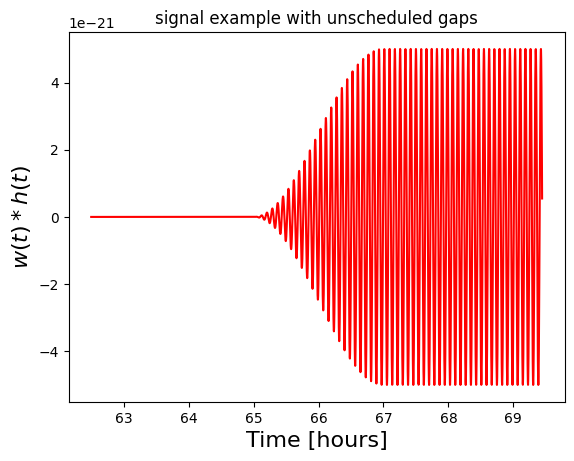

In [33]:
# Plot the signal
cor_signal=signal *cortestmask

##### use for variance in MCMC 
signalf=a_true *(np.cos((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))*2*np.pi*t
signalfd=a_true *(np.cos((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))*np.pi*t**2
cor_signalf=signalf *unscheduled_gap
cor_signalfd=signalfd *unscheduled_gap



plt.plot(t[45000:50000]/60/60,cor_signal[45000:50000], label = "window function unschedule", c = 'red')
plt.xlabel(r'Time [hours]', fontsize = 16)
plt.ylabel(r'$w(t)*h(t)$', fontsize = 16)
plt.title(r'signal example with unscheduled gaps')
plt.show()


In [34]:
### unduty percent
np.count_nonzero(cortestmask == 0)/t.shape[0]

0.1527777777777778

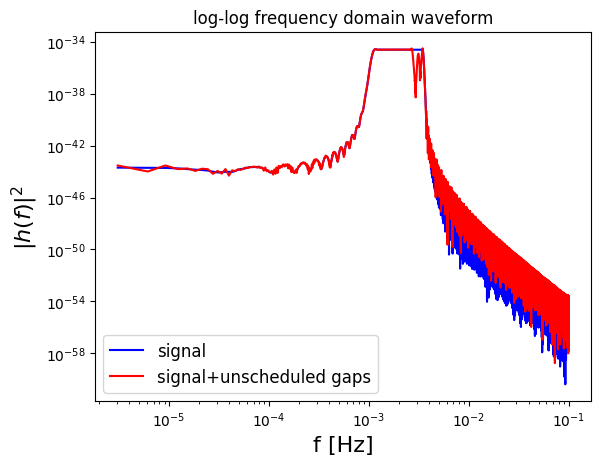

In [35]:
###################
# Frequency domain
##################
freq,PSD = freq_PSD(t,delta_t)
s_f=np.abs(FFT(signal))**2
cs_f=np.abs(FFT(cor_signal))**2

plt.loglog(freq,s_f,label="signal", color="blue")
plt.loglog(freq,cs_f,label="signal+unscheduled gaps", color="red")

plt.xlabel(r'f [Hz]', fontsize = 16)
plt.ylabel(r'$|h(f)|^2$', fontsize = 16)
plt.title(r'log-log frequency domain waveform')
plt.legend(loc = 'lower left', fontsize = 12)
plt.show()

## MCMC

Bayesian theory lies Bayes' theorem: 
\begin{eqnarray}
    p(\boldsymbol{\theta}|d_{o}) &=& \frac{p(d_{o}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(d_o)} \\
    &\propto& p(d_{o}|\boldsymbol{\theta})p(\boldsymbol{\theta}),
\end{eqnarray}
where $p(\boldsymbol{\theta}|d_{o})$ is the posterior density of unknown parameters $\boldsymbol{\theta}$ given the observation of a data stream $d_{o}$, $p(d_{o}|\boldsymbol{\theta})$ the likelihood function and $p(\boldsymbol{\theta})$ is the prior distribution, representing our knowledge about the parameters $\boldsymbol{\theta}$ before observing the data. The marginal likelihood $p(d_o) = \int_{\boldsymbol{\theta}\in\boldsymbol{\Theta}}p(d_{0}|\boldsymbol{\theta})p(\boldsymbol{\theta})\,\text{d}\boldsymbol{\theta}$ is not necessary and ingored in the MCMC here.

Under the assumption that the noise is stationary and follows a Gaussian distribution in the parameter estimation process, the likelihood is
\begin{equation}\label{eq:whittle_likelihood_signal}
p(d|\boldsymbol{\theta}) = -\frac{1}{2}\sum(d - h_m|d - h_m),
\end{equation}
where $h_m$ are model templates, generating the likelihood when inferring parameters $\boldsymbol{\theta}$ with MCMC. Window functions are employed to reduce the effects of spectral leakage in Fourier transform analysis

In [29]:
#######################################
## Classical MCMC function
#########################################
import numpy as np 
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def waveform(params,t):
    """
    This is a function. It takes in a value of the amplitude $a$, frequency $f$ and frequency derivative $\dot{f}
    and a time vector $t$ and spits out whatever is in the return function.
    We aim to estimate the parameters $a$, $f$ and $\dot{f}$.
    """
    a = params[0]
    f = params[1]
    fdot = params[2]

    return (a *(np.sin((2*np.pi)*(f*t + 0.5*fdot * t**2))))



def llike(data_f, signal_f, variance_noise_f):
    """
    Computes log likelihood 
    Assumption: Known PSD otherwise need additional term
    Inputs:
    data in frequency domain 
    Proposed signal in frequency domain
    Variance of noise
    """
    inn_prod = sum((abs(data_f - signal_f)**2) / variance_noise_f)
    # print(inn_prod)
    return(-0.5 * inn_prod)


def lprior_uniform(param,param_low_val,param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

def lpost(data_f,signal_f, variance_noise_f,param1,param2,param3, param1_low_range = -10,param1_high_range = 10,
                                                   param2_low_range = -10,param2_high_range = 10,
                                                    param3_low_range = -10,param3_high_range = 10):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param1,param1_low_range,param1_high_range) + 
                lprior_uniform(param2,param2_low_range,param2_high_range) + 
                    lprior_uniform(param3,param3_low_range,param3_high_range) + llike(data_f,signal_f,variance_noise_f))


def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

def MCMC_run(data_f, t,gaps,eps,variance_noise_f,
                   Ntotal, burnin, param_start, true_vals,
                   a_var_prop, f_var_prop, fdot_var_prop):
    '''
    Metropolis MCMC sampler
    '''
    
    # plot_direc = os.getcwd() + "/plots"
    # Set starting values

    a_chain = [param_start[0]]
    f_chain = [param_start[1]]
    fdot_chain = [param_start[2]]

    # Initial signal
    
    signal_init_t = waveform(param_start,t)  # Initial time domain signal
    
    if gaps is not None: # put gaps in waveform model
        signal_init_t *= gaps
        
    signal_init_f = FFT(signal_init_t)  # Intial frequency domain signal



                                            
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_f, signal_init_f, variance_noise_f, a_chain[0], f_chain[0],fdot_chain[0]))  # Append first value of log posterior
    lp_store = lp[0]  # Create log posterior storage to be overwritten
                 
    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 

        a_prop = a_chain[i - 1] + np.random.normal(0, np.sqrt(a_var_prop))
        f_prop = f_chain[i - 1] + np.random.normal(0, np.sqrt(f_var_prop))
        fdot_prop = fdot_chain[i - 1] + np.random.normal(0, np.sqrt(fdot_var_prop))

        # Propose a new signal 
        signal_prop_t = waveform([a_prop,f_prop,fdot_prop],t)
        if gaps is not None: # put gaps in waveform model
            signal_prop_t *= gaps
        signal_prop_f = FFT(signal_prop_t)

        
        # Compute log posterior
        lp_prop = lpost(data_f,signal_prop_f, variance_noise_f,
                        a_prop, f_prop, fdot_prop)
        
        ####
        # Perform accept_reject call
        ####
        # breakpoint()
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            f_chain.append(f_prop)    # accept a_{prop} as new sample
            a_chain.append(a_prop)    # accept f_{prop} as new sample
            fdot_chain.append(fdot_prop)    # accept \dot{f}_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
        else:  # Reject, if this is the case we use previously accepted values
            a_chain.append(a_chain[i - 1])  
            f_chain.append(f_chain[i - 1])  
            fdot_chain.append(fdot_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as .nparrays

    a_chain = np.array(a_chain)
    f_chain = np.array(f_chain)
    fdot_chain = np.array(fdot_chain)
    a_chain = a_chain[burnin:]
    f_chain = f_chain[burnin:]
    fdot_chain = fdot_chain[burnin:]

    
    return a_chain,f_chain, fdot_chain,lp  # Return chains and log posterior.

In [37]:
##############################################
# setting up for a suitable variance for MCMC
##############################################
N_t = int(2**(np.ceil(np.log2(len(t))))) 
SNR2 = inner_prod(FFT(signal),FFT(signal),PSD,delta_t,N_t)
SNR2f = inner_prod(FFT(signalf),FFT(signalf),PSD,delta_t,N_t)
SNR2fd = inner_prod(FFT(signalfd),FFT(signalfd),PSD,delta_t,N_t)
SNR2c = inner_prod(FFT(cor_signal),FFT(cor_signal),PSD,delta_t,N_t)
SNR2cf = inner_prod(FFT(cor_signalf),FFT(cor_signalf),PSD,delta_t,N_t)
SNR2cfd = inner_prod(FFT(cor_signalfd),FFT(cor_signalfd),PSD,delta_t,N_t)

a_mcmcvar=a_true**2/SNR2
ca_mcmcvar=a_true**2/SNR2c
f_mcmcvar=1/SNR2f
cf_mcmcvar=1/SNR2cf
fd_mcmcvar=1/SNR2fd
cfd_mcmcvar=1/SNR2cfd

In [40]:
# MCMC - parameter estimation

Ntotal = 31000  # Total number of iterations
burnin = 21000   # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters

variance_noise_f = N_t * PSD / (4 * delta_t)

delta_a = np.sqrt(a_mcmcvar)
delta_f = np.sqrt(f_mcmcvar)
delta_dotf = np.sqrt(fd_mcmcvar)

param_start = [a_true + 100*delta_a, f_true + 75*delta_f, fdot_true - 75*delta_dotf]  # Starting values
# param_start = [a_true , f_true , fdot_true]  # Starting values

true_vals = [a_true,f_true, fdot_true]   # True values

a_chain,f_chain,fdot_chain,lp  = MCMC_run(FFT(signal), t,None,0,variance_noise_f,
                                Ntotal, burnin, param_start,true_vals,
                                a_var_prop = delta_a**2,
                                f_var_prop = delta_f**2,
                                fdot_var_prop = delta_dotf**2)

100%|██████████| 30999/30999 [01:45<00:00, 293.42it/s]


In [42]:
delta_ac = np.sqrt(ca_mcmcvar)
delta_fc = np.sqrt(cf_mcmcvar)
delta_dotfc = np.sqrt(cfd_mcmcvar)

a_chain_c,f_chain_c,fdot_chain_c,lp  = MCMC_run(FFT(cor_signal), t,unscheduled_gap,0, variance_noise_f,
                                Ntotal, burnin, param_start,true_vals,
                                a_var_prop = delta_ac**2,
                                f_var_prop = delta_fc**2,
                                fdot_var_prop = delta_dotfc**2)

100%|██████████| 30999/30999 [01:46<00:00, 292.24it/s]


In [43]:
[np.mean(a_chain_c),np.mean(f_chain_c),np.mean(fdot_chain_c)]

[4.482747146391558e-21, 0.0010000115872078092, 9.999864447582757e-09]

In [44]:
a_chain_r,f_chain_r,fdot_chain_r,lp  = MCMC_run(FFT(forcastoutput), t,None,0,variance_noise_f,
                                Ntotal, burnin, param_start,true_vals,
                                a_var_prop = delta_a**2,
                                f_var_prop = delta_f**2,
                                fdot_var_prop = delta_dotf**2)

100%|██████████| 30999/30999 [01:44<00:00, 295.51it/s]


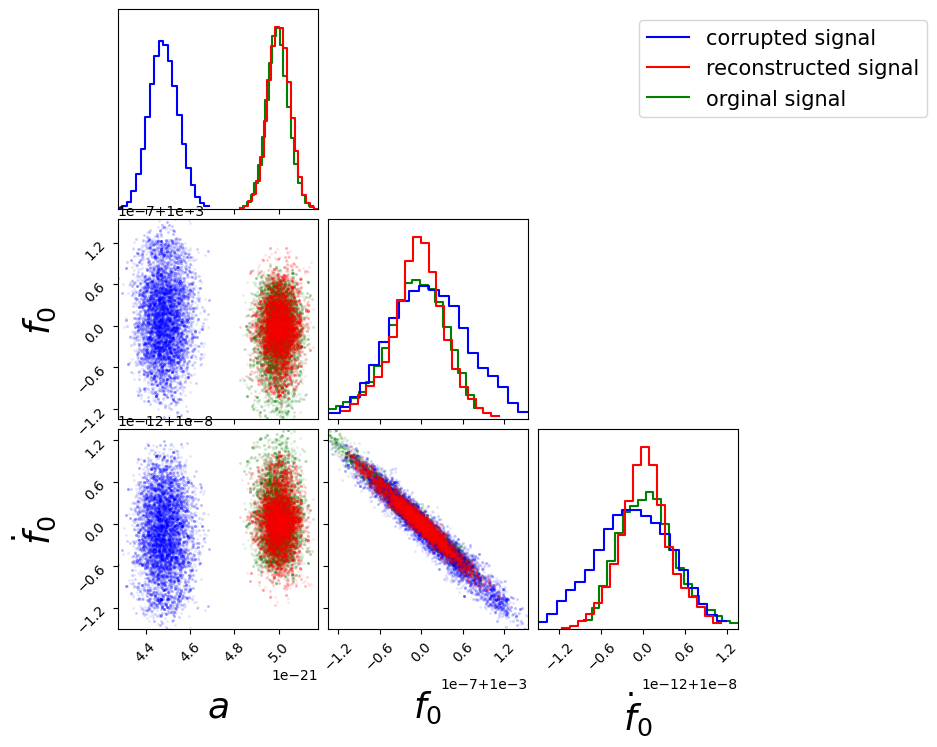

In [52]:
import corner
params = [r'$a$', r'$f_{0}$', r'$\dot{f}_{0}$'] 
samples_MCMC = np.column_stack([a_chain[::], f_chain[::], fdot_chain[::]])
samples_MCMC_c = np.column_stack([a_chain_c[::], f_chain_c[::], fdot_chain_c[::]])
samples_MCMC_r = np.column_stack([a_chain_r[::], f_chain_r[::], fdot_chain_r[::]])


figure = corner.corner(samples_MCMC,bins = 20,color = 'green',plot_datapoints=True,plot_contours=False,plot_density=False,smooth1d=True,
                    labels=params, 
                    label_kwargs = {"fontsize":26},set_xlabel = {'fontsize': 26},
                    show_titles=False, title_fmt='.3E',smooth = True)
plt.legend(['orginal signal'], loc='upper right')

figure=corner.corner(samples_MCMC_c,bins = 20,fig=figure,color = 'blue',plot_datapoints=True,plot_contours=False,plot_density=False,smooth1d=True,
                    labels=params, 
                    label_kwargs = {"fontsize":26},set_xlabel = {'fontsize': 26},
                    show_titles=False,smooth = True)
plt.legend(['signal with a long gap'], loc='upper right')

figure=corner.corner(samples_MCMC_r,bins = 20,fig=figure,color = 'red',plot_datapoints=True,plot_contours=False,plot_density=False,smooth1d=True,
                    labels=params, 
                    label_kwargs = {"fontsize":26},set_xlabel = {'fontsize': 26},
                    show_titles=False,smooth = True)
plt.legend(['reconstructed signal with a long gap'], loc='upper right')


import matplotlib.patches as mpatches
import matplotlib.lines as mlines
    
# SET LEGEND
blue_line = mlines.Line2D([], [], color='blue', label=r'corrupted signal')
red_line = mlines.Line2D([], [], color='red', label=r'reconstructed signal')
black_line = mlines.Line2D([], [], color='green', label='orginal signal')




plt.legend(handles=[blue_line,red_line,black_line], fontsize = 15, frameon = True, bbox_to_anchor=(2, 3.1), loc="upper right")

    
plt.show() 



## KL divergence
KL divergence with samples of the posterior distribution is defined with the kernel density estimation. Let $p(\boldsymbol{\theta}|h_{G}(h_{C}(\hat{d}_o)))$ be the posterior of the imputed signal and $q(\boldsymbol{\theta}|d_o)$ be the posterior of original signal, the KL divergence is 

\begin{align}
D_{KL}(q(\boldsymbol{\theta}|d_o)||p(\boldsymbol{\theta}|h_{G}(h_{C}(\hat{d}_o)))) &= \int q(\boldsymbol{\theta}|d_o) \log \left(\frac{q(\boldsymbol{\theta}|d_o)}{p(\boldsymbol{\theta}|h_{G}(h_{C}(\hat{d}_o)))}\right) d\boldsymbol{\theta}\\
&\approx \frac{1}{n} \sum_{i=1}^{n} \left(\log\hat{Q}(\boldsymbol{\theta}_i|d_o)-\log{\hat{P}(\boldsymbol{\theta}_i|h_{G}(h_{C}(\hat{d}_o)))}\right)
\end{align}

where $\boldsymbol{\theta}_i$ is the $i$-th samples from the posterior distribution of the original complete signal, $\boldsymbol{\theta}_i\sim q(\boldsymbol{\theta}|d_o)$ and, $\hat{P}(.)$ and $\hat{Q}(.)$ are the estimated probability density based on Gaussian Kernel Density Estimation. Therefore, for posterior of the corrupted signal $\hat{d}_o$, the KL divergence can be

\begin{align}
D_{KL}(q(\boldsymbol{\theta}|d_o)||p(\boldsymbol{\theta}|\hat{d}_o))
&\approx \frac{1}{n} \sum_{i=1}^{n}  \left(\log\hat{Q}(\boldsymbol{\theta}_i|d_o)-\log{\hat{P}(\boldsymbol{\theta}_i|\hat{d}_o)}\right)
\end{align}


In [67]:
from scipy import stats

kde1 = stats.gaussian_kde(samples_MCMC.T)
density1 = kde1(samples_MCMC[::100,].T)
kde2 = stats.gaussian_kde(samples_MCMC_c.T)
density2 = kde2(samples_MCMC[::100,].T)
kde3 = stats.gaussian_kde(samples_MCMC_r.T)
density3 = kde3(samples_MCMC[::100,].T)

In [69]:
from scipy.stats import entropy

# Calculate the KL divergence
kl_divergence1 = entropy(density1, density3)
kl_divergence2 = entropy(density1, density2)
print("KL_DIV_corrupt&complete:",kl_divergence2)
print("KL_DIV_imputed&complete:",kl_divergence1)

KL_DIV_corrupt&complete: 117.23289174325042
KL_DIV_imputed&complete: 0.07124583491028746
